In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [2]:
def generate_P_matrix(p):
    """
    P_{kij} = P(Agent 0 observes i, Agent 1 observes j | Currently in state k)
    """
    p1_matrix = torch.tensor([
        [1-p,p,0,0],
        [p,1-p,0,0],
        [0,0,1-p,p],
        [0,0,p,1-p]
    ], dtype=torch.float32).unsqueeze(-1)
    p2_matrix = torch.tensor([
        [1-p,0,p,0],
        [0,1-p,0,p],
        [p,0,1-p,0],
        [0,p,0,1-p]
    ], dtype=torch.float32).unsqueeze(-1)
    return torch.matmul(p1_matrix,p2_matrix.mT)

In [3]:
def generate_Q_matrix(policy_1, policy_2):
    """
    Q_{lij} = Pr(Going to state l | Agent 0 sees i, Agent 1 sees j)
    """
    p1 = policy_1.unsqueeze(-1)
    p2 = policy_2.unsqueeze(-1)
    return torch.stack(((1-p1)@(1-p2).T, (1-p1)@p2.T, p1@(1-p2).T, p1@p2.T))


In [4]:
p_i = torch.tensor([0.1, 0.2, 0.3, 0.4]).float()
p_j = torch.tensor([0.5, 0.6, 0.7, 0.8]).float()
p = 0.01

P = generate_P_matrix(p)
Q = generate_Q_matrix(p_i, p_j)

print(P.dtype)
print(Q.dtype)
PQ = torch.einsum("kij, lij -> kl", [P, Q])
#PQ = torch.tensordot(P, Q)
print(PQ)


torch.float32
torch.float32
tensor([[0.4477, 0.4513, 0.0503, 0.0507],
        [0.3188, 0.4822, 0.0792, 0.1198],
        [0.2111, 0.4879, 0.0909, 0.2101],
        [0.1214, 0.4796, 0.0806, 0.3184]])


In [34]:
class NoisyIPD:
    def __init__(self, game, p_i, p_j, p, gamma):
        """
        Note: self.game should be 4x2
        """
        self.game = game.float()
        self.p_i = torch.nn.Parameter(p_i.float(), requires_grad=True)
        self.p_j = torch.nn.Parameter(p_j.float(), requires_grad=True)
        self.policies = (self.p_i, self.p_j)
        self.p = p
        self.gamma = gamma
        self.P = generate_P_matrix(self.p)
        self.Q = generate_Q_matrix(self.p_i, self.p_j)
        self.values_0, self.values_1 = self.find_values(self.P, self.Q)


    def find_values(self, P, Q):
        
        I = torch.eye(4)  # Identity matrix of size 4x4
            
        # sum over ij of P_kij * Q_lij

        PQ = torch.einsum("kij, lij -> kl", P, Q)
#        self.subtracted_matrix = I - self.gamma * torch.matmul(self.P, self.Q)
        self.subtracted_matrix = I - self.gamma * PQ
        
        inverse_matrix = torch.linalg.solve(self.subtracted_matrix, torch.eye(4))
        values = torch.matmul(inverse_matrix, self.game.T)

        return values.T


    def optimize(self, num_iterations, policy_index, learning_rate=0.05):
        #  logit_p_i = torch.log(self.p_i / (1 - self.p_i)).clone().detach().requires_grad_(True)  # Logit transformation
        policy = self.policies[policy_index]
        rival_policy = self.policies[1-policy_index]
        rival_policy.requires_grad_(False)

        logit_policy = torch.logit(policy).clone().detach().requires_grad_(True)  # Logit transformation

        optimizer = torch.optim.Adam([logit_policy], lr=learning_rate)

        storage = {}
        storage["policy"] = []
        storage["values"] = []
        storage["total_value"] = []
        storage["loss"] = []

        for i in range(num_iterations):
            #print(f"\n Run {i}")
            optimizer.zero_grad()

            policy = torch.sigmoid(logit_policy)

            if policy_index == 0:
                self.Q = generate_Q_matrix(policy, rival_policy)
            else:
                self.Q = generate_Q_matrix(rival_policy, policy)
            
            values = self.find_values(self.P, self.Q)

            loss = -values[policy_index].sum()   # We want to maximize self.values_0, so we negate it for minimization
            #  loss.backward(retain_graph=True)
            loss.backward()

            #print("p_i values:", self.p_i)
            #print("value for agent i:", self.values_0)
            #print("total value for agent i:", self.values_0.sum())
            #print("loss:", loss)  # Check the value of the loss
            storage["policy"].append(policy)
            storage["values"].append(values[policy_index])
            storage["total_value"].append(values[policy_index].sum())
            storage["loss"].append(loss.item())

            optimizer.step()
        
        
        return storage

#            with torch.no_grad():  # We don't want these operations to be tracked in the computational graph
#                eps = 1e-7
#                logit_p_i = torch.log((self.p_i + eps) / (1 - self.p_i + eps)).clone().detach().requires_grad_(True)



In [40]:

prisoners_dilemma = torch.tensor([[3, 0, 4, 1],
                                  [3, 4, 0, 1]])
gamma = 0.999

game_obj = NoisyIPD(game = prisoners_dilemma,
                        p_i = torch.tensor([0.1, 0.2, 0.3, 0.4]).float(),
                        p_j = torch.tensor([0.5, 0.6, 0.7, 0.8]).float(),
                        p = p,
                        gamma = gamma)

#storage_vals = game_obj.optimize_pi()

In [41]:
storage = game_obj.optimize(policy_index=1, num_iterations=1000)

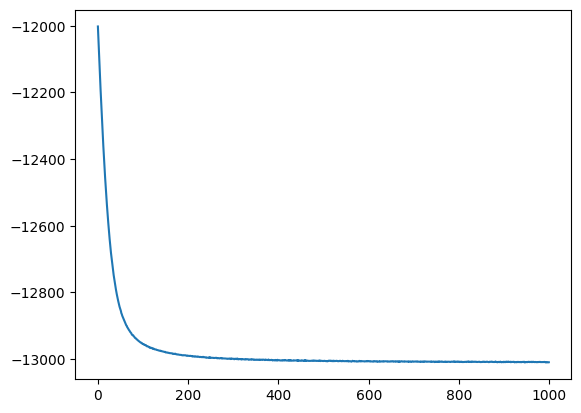

In [42]:
storage['loss']
plt.plot(storage['loss'])
plt.show()

In [48]:
storage['policy']

[tensor([0.5000, 0.6000, 0.7000, 0.8000], grad_fn=<SigmoidBackward0>),
 tensor([0.5125, 0.6119, 0.7104, 0.8079], grad_fn=<SigmoidBackward0>),
 tensor([0.5250, 0.6237, 0.7206, 0.8155], grad_fn=<SigmoidBackward0>),
 tensor([0.5374, 0.6354, 0.7305, 0.8229], grad_fn=<SigmoidBackward0>),
 tensor([0.5497, 0.6469, 0.7401, 0.8301], grad_fn=<SigmoidBackward0>),
 tensor([0.5619, 0.6583, 0.7495, 0.8370], grad_fn=<SigmoidBackward0>),
 tensor([0.5740, 0.6694, 0.7586, 0.8437], grad_fn=<SigmoidBackward0>),
 tensor([0.5859, 0.6804, 0.7674, 0.8501], grad_fn=<SigmoidBackward0>),
 tensor([0.5977, 0.6912, 0.7759, 0.8564], grad_fn=<SigmoidBackward0>),
 tensor([0.6092, 0.7018, 0.7840, 0.8624], grad_fn=<SigmoidBackward0>),
 tensor([0.6205, 0.7121, 0.7919, 0.8681], grad_fn=<SigmoidBackward0>),
 tensor([0.6316, 0.7223, 0.7995, 0.8737], grad_fn=<SigmoidBackward0>),
 tensor([0.6424, 0.7322, 0.8067, 0.8790], grad_fn=<SigmoidBackward0>),
 tensor([0.6529, 0.7418, 0.8136, 0.8841], grad_fn=<SigmoidBackward0>),
 tenso

In [43]:
storage['policy'][-1]
plt.plot(storage['policy'])

tensor([0.9418, 0.9992, 0.9723, 0.9996], grad_fn=<SigmoidBackward0>)